In [2]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import dask.dataframe as dd
import seaborn as sns

pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

/home/sam/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Sun Jun 30 09:02:52 EDT 2019


In [3]:
import itertools
import random

In [4]:
def extract_epsilon(df):
    s = df.reset_index().path.astype(str)
    def get_eps(m):
        eps=m.split('_E')[1].split('_R')[0]
        if float(eps)>20:
            return float(eps)/100
        else:
            return float(eps)
    return s.map(get_eps).values

def extract_replicate(df):
    s = df.reset_index().path.astype(str)
    def get_rep(m):
        return  m.split('_E')[1].split('_R')[1]
    return s.map(get_rep).values
#t['i'] = extract_replicate(t)
#t

In [5]:
def get_clean_data(state, threshold, geolevel, cutoff_small_pop):
    newnames={'TABBLKST':'STATE','TABBLKCOU':'COUNTY','ENUMDIST':'DIST','RTYPE':'GQ','QAGE':'AGE','CENHISP':'HISP','CENRACE':'RACE'}
    
    #actual data from IPUMS
    cef = pd.read_csv(f'data/{state}/the_real_{state}', usecols=[1,2,3,4,5,6,7], sep='\t')
    cef.rename(columns=newnames, inplace=True)
    assert np.all(cef.COUNTY % 10 == 0)
    cef['COUNTY'] = (cef['COUNTY']/10).astype(int)
    
    #compute number of low count bins per geounit
    ccef = cef.groupby(geolevel)  
    countyarray=[]
    numemptyarray=[]
    snea=[]
    for group in ccef:
        cdata=group[1]
        #print(cdata)
        numempty=0
        for ctype in itertools.product([1,2,3,4,5,6],[1,2],[17,18]):
            #print(ctype)
            race, hisp, age= ctype
            if len(cdata[cdata.RACE.isin([race]) & cdata.HISP.isin([hisp]) & cdata.AGE.isin([age])])<=threshold:
                numempty+=1
        countyarray.append(group[0])
        numemptyarray.append(numempty-1/4+random.random()/2)
        snea.append(numempty)
       # print(f'County {group[0]}: {numempty} cells')
    
    #cemp dataframe: row=geounit, column NEMPTY= number of low count bins + noise, column AEMPTY=number low count bins
    cemp=pd.DataFrame({geolevel:countyarray, 'NEMPTY':numemptyarray, 'AEMPTY':snea})
    
    #data from all 32 runs
    df = dd.read_csv(f'data/{state}/{state}_E*', include_path_column=True, usecols=[1,2,3,4,5,6,7], sep='\t')
    df=df.rename(columns=newnames)
    assert np.all(df.COUNTY % 10 == 0)
    df['COUNTY'] = (df['COUNTY']/10).astype(int)

    #c dataframe: row=geounit and path combos, column dp_count= reported population for that run and geounit, column epislon and i for which run
    c = df.groupby(['path', geolevel]).HISP.count().compute()
    c.name = 'dp_count'
    c = c.reset_index()
    c['i'] = extract_replicate(c)
    c['epsilon'] = extract_epsilon(c)
    
    #exact_value dataframe: row= geounit, column=population of geounit as reported in CEF
    exact_val = cef.groupby(geolevel).size()
    exact_val.name = 'exact_count'
    exact_val=exact_val.reset_index()
    tt=pd.merge(c, exact_val, on=geolevel)
    tt=pd.merge(tt, cemp.reset_index(), on=geolevel)
    tt['dp_m_exact'] = tt.dp_count-tt.exact_count 
    tt['pchange']=tt['dp_m_exact']/tt['exact_count']
    
    # extra columns pchange, NEMPTY, AEMPTY
    aves=tt.groupby(['epsilon',geolevel]).pchange.mean()
    aves=aves.reset_index()
    rawaves=tt.groupby(['epsilon',geolevel]).dp_m_exact.mean()
    rawaves=rawaves.reset_index()
    locations=tt.groupby(['epsilon',geolevel]).NEMPTY.min()
    locations=locations.reset_index()
    truelocations=tt.groupby(['epsilon',geolevel]).AEMPTY.min()
    truelocations=truelocations.reset_index()
    
    # merge pchang ave, dp_m_exact ave, NEMPTY, AEMPTY, exact_val into one df with rows 
    la=pd.merge(locations, aves, on=[geolevel,'epsilon'])
    la=pd.merge(la, truelocations, on=[geolevel,'epsilon'])
    la=pd.merge(la,rawaves, on=[geolevel,'epsilon'])
    la=pd.merge(la,exact_val, on=[geolevel])
   
    
    #get rid of small counts
    tt=tt[tt.exact_count>cutoff_small_pop]
    la=la[la.exact_count>cutoff_small_pop]

    #average by AEMPTY
    ave_by_empty_p=la.groupby(['AEMPTY', 'epsilon']).pchange.mean()
    ave_by_empty_p.reset_index()
    ave_by_empty_raw=la.groupby(['AEMPTY', 'epsilon']).dp_m_exact.mean()
    ave_by_empty_raw.reset_index()
    aa=pd.merge(ave_by_empty_p, ave_by_empty_raw, on=['AEMPTY','epsilon'])
    aa=aa.reset_index()

    return tt, la, aa
    
    
    
    

In [6]:
def plot(full, by_eps, by_empty, att, eps, state, geounit, do_full):
    cfull=full[full.epsilon==eps]
    cby_eps=by_eps[by_eps.epsilon==eps]
    cby_empty=by_empty[by_empty.epsilon==eps]
    x=[i**(1/2)/10 for i in cby_eps['exact_count']]
    plt.axhline( y=0, linestyle='--', color='k')
    if do_full:
        plt.scatter( cfull['NEMPTY'], cfull[att], marker='x', s=5)
    plt.scatter( cby_eps['NEMPTY'], cby_eps[att], marker='o', s=x)
    plt.scatter( cby_empty['AEMPTY'], cby_empty[att], marker='D', s=25)
    plt.title(f'Average change in {geounit} population by number of small bins for {state} at epsilon={eps}')
    plt.xlabel(f'Number of small bins in {geounit}')
    plt.ylabel(f'Average change in population of {geounit}')
    plt.grid(b=True)
    

In [7]:
def plot_all(full, by_eps, by_empty, att, state, geolevel, each):
    for eps in [.25,.50,.75,1.0,2.0,4.0,6.0,8.0]:
        plot(full, by_eps, by_empty, att, eps, state, geolevel, each)
        plt.show()

In [6]:
MA_D_full, MA_D_by_eps, MA_D_by_empty= get_clean_data('MA', 2, 'DIST', 0)
MA_C_full, MA_C_by_eps, MA_C_by_empty= get_clean_data('MA', 2, 'COUNTY', 0)
GA_D_full, GA_D_by_eps, GA_D_by_empty= get_clean_data('GA', 2, 'DIST', 0)
GA_C_full, GA_C_by_eps, GA_C_by_empty= get_clean_data('GA', 2, 'COUNTY', 0)

/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)
/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)
/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)
/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)


In [88]:
t2full, t2by_eps, t2by_empty= get_clean_data('MA', 2, 'DIST', 0)

/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)


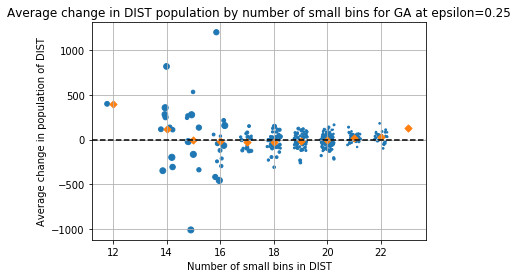

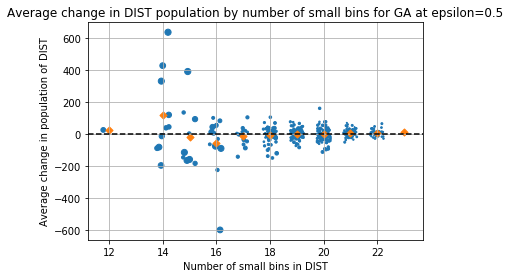

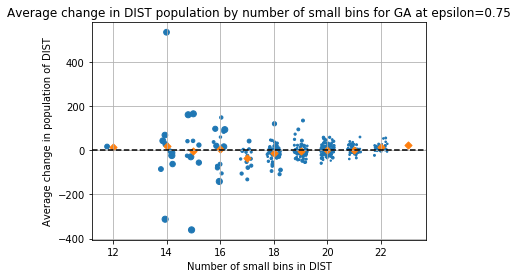

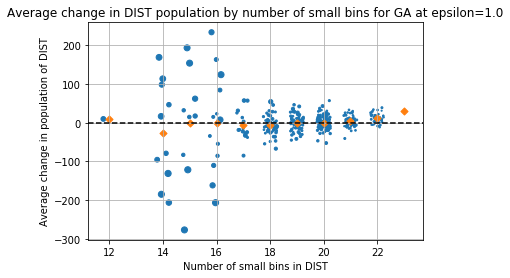

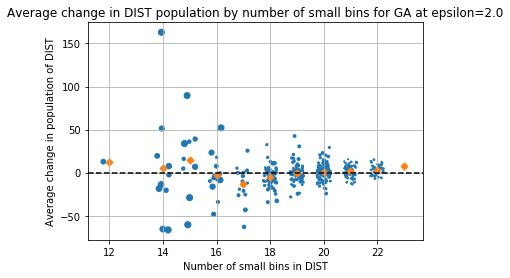

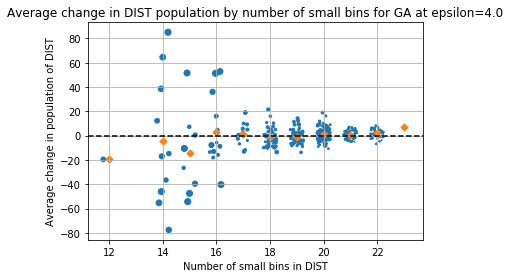

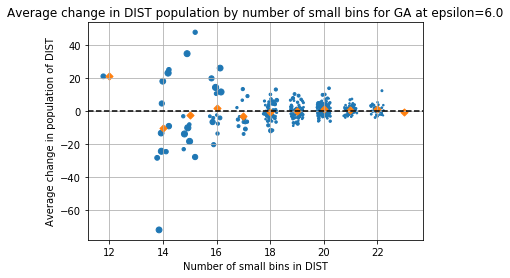

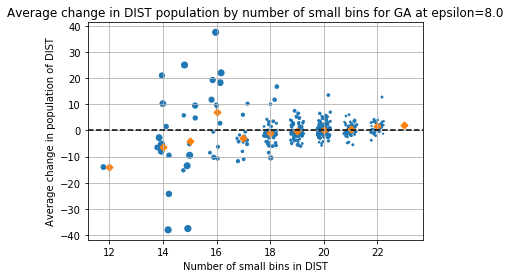

In [10]:
plot_all(GA_D_full, GA_D_by_eps, GA_D_by_empty, 'dp_m_exact', 'GA', 'DIST', False)

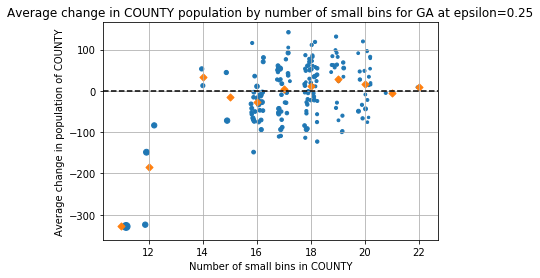

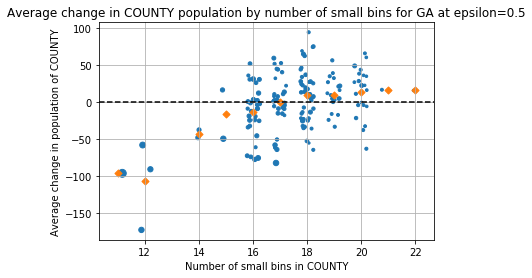

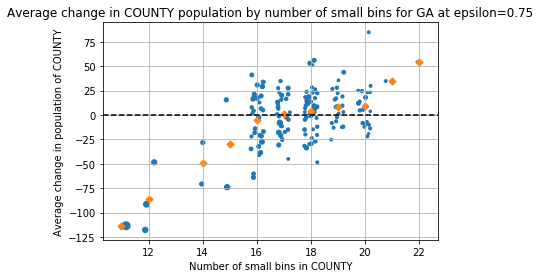

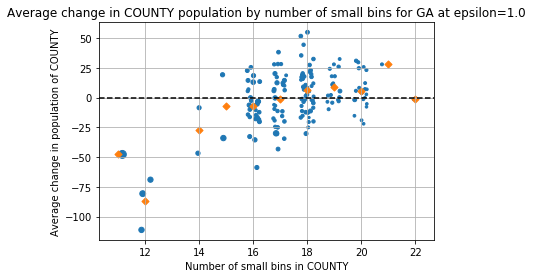

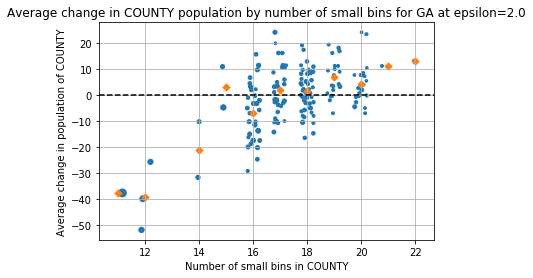

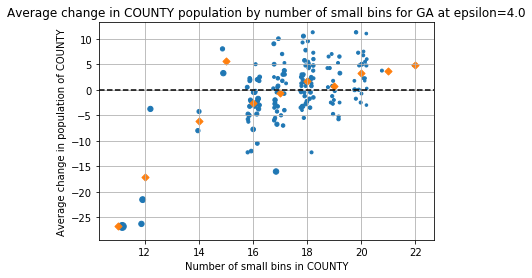

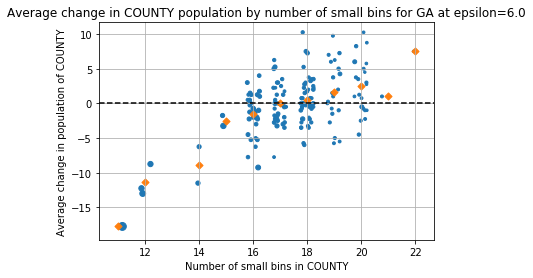

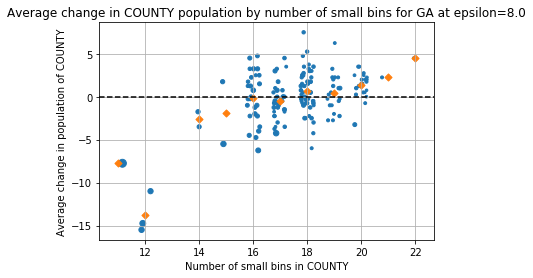

In [11]:
plot_all(GA_C_full, GA_C_by_eps, GA_C_by_empty, 'dp_m_exact', 'GA', 'COUNTY', False)

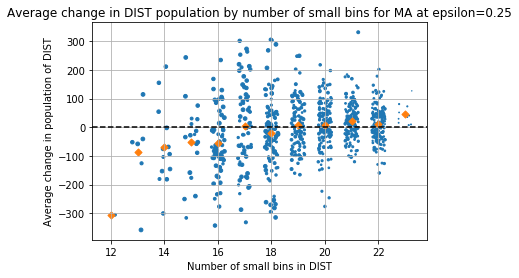

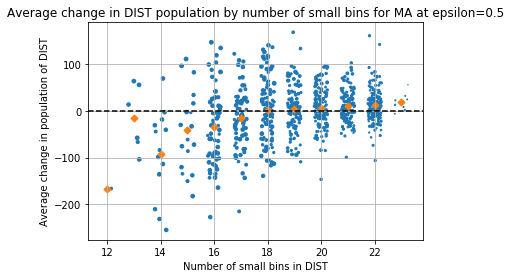

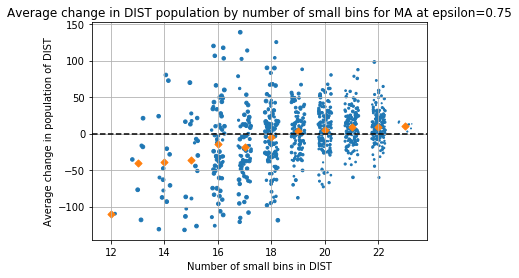

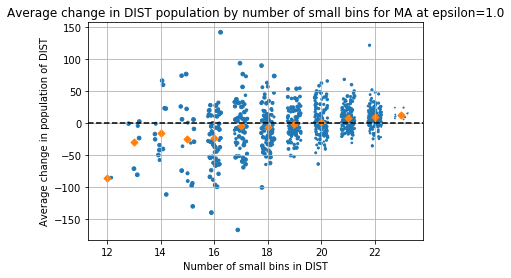

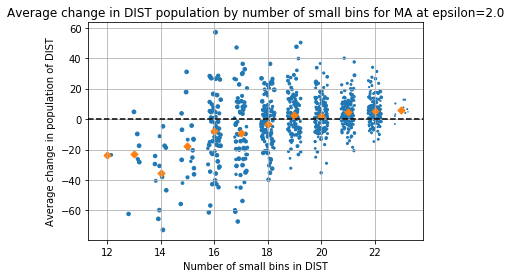

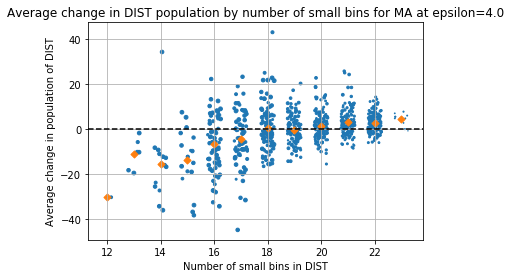

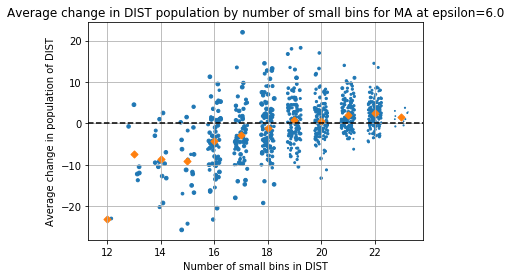

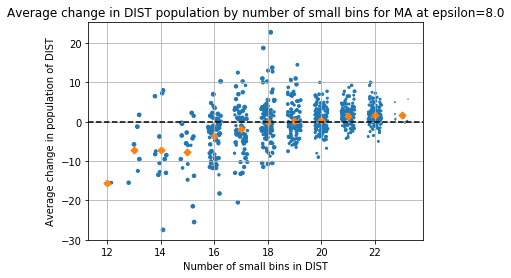

In [12]:
plot_all(MA_D_full, MA_D_by_eps, MA_D_by_empty, 'dp_m_exact', 'MA', 'DIST', False)

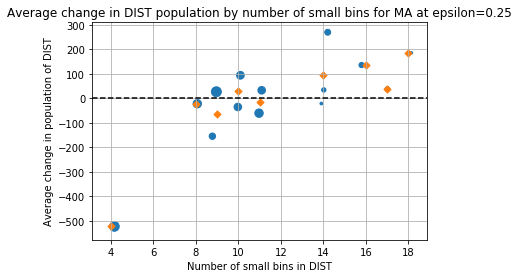

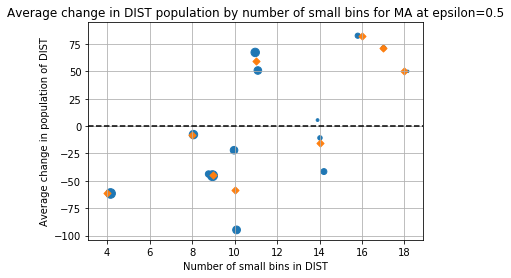

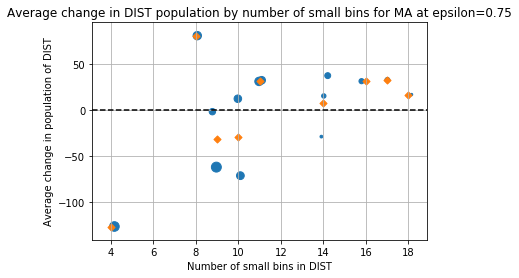

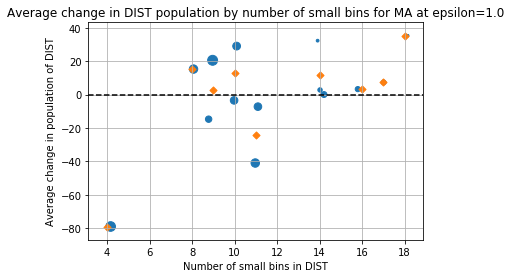

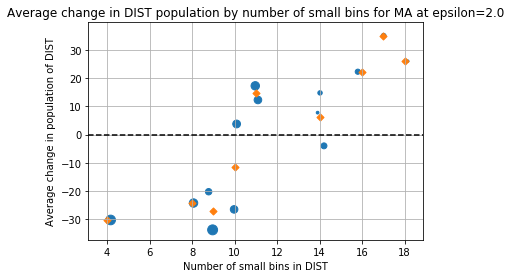

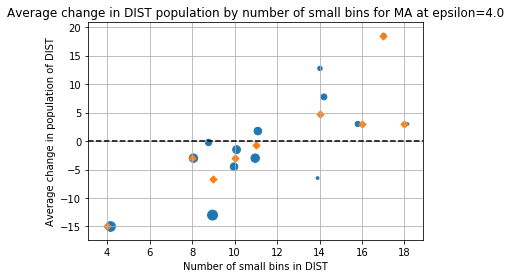

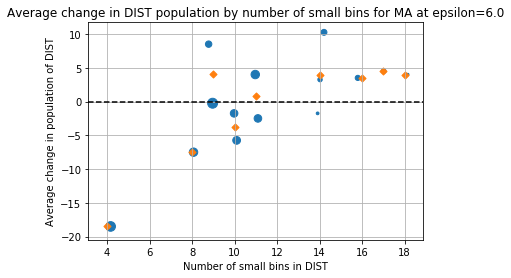

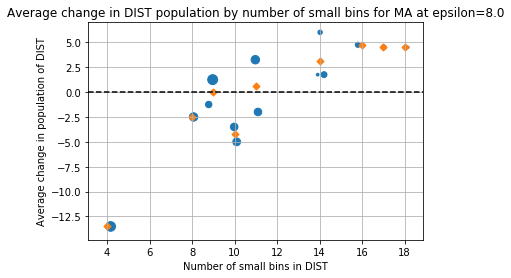

In [13]:
plot_all(MA_C_full, MA_C_by_eps, MA_C_by_empty, 'dp_m_exact', 'MA', 'DIST', False)

(array([ 8., 11., 15., 12., 12., 15.,  7., 19., 18., 19., 16., 23., 22.,
        30., 19., 16., 13., 15., 27., 25., 14., 24., 25., 15., 24., 13.,
        18., 11.,  9.,  9., 11., 11.,  8.,  9.,  4.,  2.,  4.,  8.,  3.,
         4.,  3.,  5.,  1.,  3.,  4.,  7.,  4.,  4.,  7.,  5.,  3.,  4.,
         3.,  3.,  3.,  4.,  3.,  7.,  3.,  4.,  2.,  4.,  4.,  5.,  3.,
         3.,  2.,  4.,  1.,  2.,  5.,  1.,  4.,  2.,  2.,  2.,  1.,  1.,
         2.,  2.,  0.,  2.,  5.,  4.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,
         1.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  1.,  1.,  2.,  2.,
         1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  1.,  4.,  2.,  1.,  0.,  0.,  2.,  0.,
         0.,  0.,  1.,  1.,  4.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  1.,
         1.,  1.,  2.,  1.,  2.,  3.]),
 array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
          900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
         1800, 

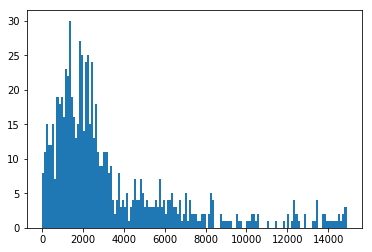

In [34]:
plt.hist(MA_D_by_eps[MA_D_by_eps.epsilon==.25].exact_count, bins=[100*i for i in range(0, 150)])

(array([ 2.,  8.,  5.,  6., 12., 18., 14., 25., 24., 19., 28., 24., 14.,
        14.,  8.,  7., 12.,  4.,  9.,  9.,  4.,  4.,  4.,  3.,  3.,  5.,
         1.,  4.,  5.,  6.,  3.,  4.,  3.,  3.,  0.,  1.,  1.,  3.,  3.,
         3.,  1.,  0.,  0.,  1.,  3.,  4.,  2.,  1.,  0.,  1.,  1.,  1.,
         0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,
         1.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  1.,  2.,  1.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
          900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
         1800, 

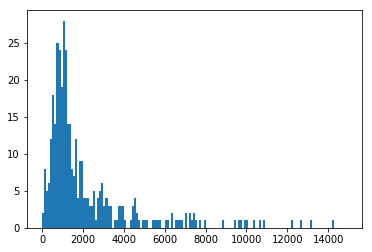

In [32]:
plt.hist(GA_D_by_eps[GA_D_by_eps.epsilon==.25].exact_count, bins=[100*i for i in range(0, 150)])

(array([ 0.,  0.,  1.,  1.,  5.,  6.,  7., 12., 12., 10., 12.,  9.,  9.,
         4.,  5.,  8.,  5.,  1.,  5.,  2.,  6.,  4.,  2.,  2.,  3.,  2.,
         3.,  2.,  4.,  1.,  0.,  3.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
        54000, 55000, 56000, 57000, 58000, 59000]),
 <a list of 59 Patch objects>)

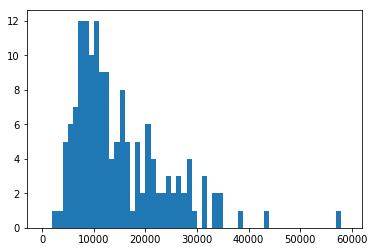

In [27]:
plt.hist(GA_C_by_eps[GA_C_by_eps.epsilon==.25].exact_count, bins=[1000*i for i in range(0, 60)])

In [81]:
def plot_GA_county(by_eps, by_empty, att, eps, filename):
    cby_eps=by_eps[by_eps.epsilon==eps]
    cby_empty=by_empty[by_empty.epsilon==eps]
    x=[i**(1/2)/10 for i in cby_eps['exact_count']]
    plt.axhline( y=0, linestyle='--', color='k')
    plt.scatter( cby_eps['NEMPTY'], cby_eps[att], marker='o', s=x)
    plt.scatter( cby_empty['AEMPTY'], cby_empty[att], marker='D', s=25)
    plt.title(f'Reported GA county populations for epsilon={eps}')
    plt.xlabel(f'Number of small bins in county')
    plt.ylabel(f'Reported - actual population')
    plt.xticks(np.arange(11, 23, step=1))
    plt.yticks(np.arange(-100, 125, step=25))
    plt.grid(b=True)
    #sizes=[10000,50000]
    #texts = [f'{size}' for size in sizes]

    #patches=[]
    #patches = [ plt.plot([],[], marker="o", ms=sizes[i]**(1/2.0)/10.0, ls="", mec=None, color='#1f77b4',
     #          label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    #patches.append( plt.plot([],[], marker="D", ls="", mec=None, color='orange',label='average'))
    #plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5))
    if filename!=False:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [8]:
GA_C_full, GA_C_by_eps, GA_C_by_empty= get_clean_data('GA', 2, 'COUNTY', 0)

/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)


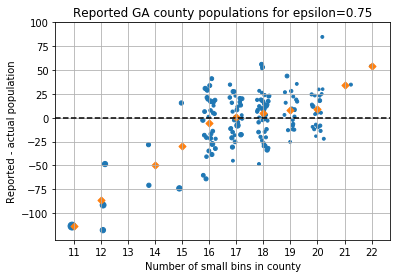

In [82]:
plot_GA_county(GA_C_by_eps, GA_C_by_empty, 'dp_m_exact', .75, 'GA_county_75.pdf')

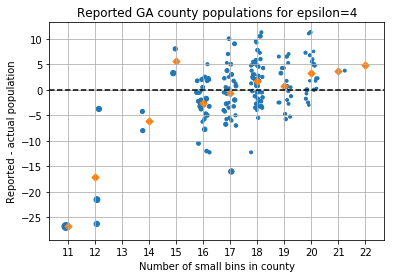

In [80]:
plot_GA_county(GA_C_by_eps, GA_C_by_empty, 'dp_m_exact', 4, 'GA_county_4_alt.pdf')

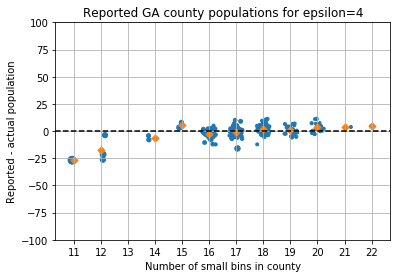

In [83]:
plot_GA_county(GA_C_by_eps, GA_C_by_empty, 'dp_m_exact', 4, 'GA_county_4.pdf')

In [26]:
import matplotlib.patches as mpatches

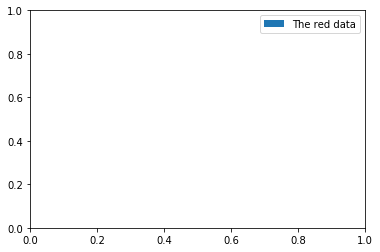

In [31]:
small = mpatches.Circle( 0,0, label='The red data')
plt.legend(handles=[small])
plt.show()

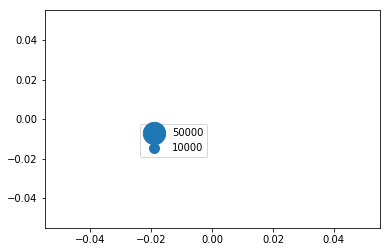

In [59]:
colors = ["g", "w"]

sizes=[50000,10000]
texts = [f'{size}' for size in sizes]

patches=[]
patches = [ plt.plot([],[], marker="o", ms=sizes[i]**(1/2.0)/10.0, ls="", mec=None, color='#1f77b4',
           label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
#patches.append( plt.plot([],[], marker="D", ls="", mec=None, color='orange',label='average'))
plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5))
plt.show()